## Prerequisite

Make sure you ran `snakemake` in this directory and have obtained all the files (stored under `output/`).

## Load and visualize the predictions

In [45]:
# Gloal 
models = ['DeepSEA/predict', 'Basset']

### Loading predictions from the tsv output

In [46]:
import kipoi
import seaborn as sns
import pandas as pd

In [47]:
merge_cols = ['metadata/ranges/chr', 'metadata/ranges/start', 'metadata/ranges/end', 'metadata/ranges/strand', 'metadata/ranges/id']

In [48]:
d = kipoi.get_model_descr("DeepSEA/predict")

In [49]:
def read_preds_tsv(model, output_dir):
    df = pd.read_table("{}/{}.tsv".format(output_dir, model))
    df.set_index(merge_cols, inplace=True)
    assert df.columns.str.startswith("preds").all()
    df.columns = df.columns.str.replace("preds", model)
    
    if len(df.columns) > 1:
        # multi-task model
        try:
            descr = kipoi.get_model_descr(model)
            df.columns = model + "/" + pd.Series(descr.schema.targets.column_labels)
        except:
            pass
    return df

In [50]:
df = pd.concat([read_preds_tsv(m, output_dir='output') for m in models], axis=1)

In [51]:
df.head()

DeepSEA/predict/8988T_DNase_None  \
metadata/ranges/chr metadata/ranges/start metadata/ranges/end metadata/ranges/strand metadata/ranges/id                                     
chr22               135543                136543              *                      0                                     0.0816           
                    135876                136876              *                      1                                     0.0670           
                    137274                138274              *                      2                                     0.0445           
                    134028                135028              *                      3                                     0.0025           
                    138535                139535              *                      4                                     0.0008           

                                                                                                         DeepSEA/predict/AoSMC_DNase_None  \
metadata/ranges/chr metadata/ranges/start metadata/ranges/end metadata/ranges/strand metadata/ranges/id                                     
chr22               135543                136543              *                      0                                     0.0687           
                    135876                136876              *                      1                                     0.0106           
                    137274                138274              *                      2                                     0.0054           
                    134028                135028              *                      3                                     0.0005           
                    138535                139535              *                      4                                     0.0054           

                                                                                                         DeepSEA/predict/Chorion_DNase_None  \
metadata/ranges/chr metadata/ranges/start metadata/ranges/end metadata/ranges/strand metadata/ranges/id                                       
chr22               135543                136543              *                      0                                     0.0063             
                    135876                136876              *                      1                                     0.0302             
                    137274                138274              *                      2                                     0.0339             
                    134028                135028              *                      3                                     0.0010             
                    138535                139535              *                      4                                     0.0011             

                                                                                                         DeepSEA/predict/CLL_DNase_None  \
metadata/ranges/chr metadata/ranges/start metadata/ranges/end metadata/ranges/strand metadata/ranges/id                                   
chr22               135543                136543              *                      0                                     0.0568         
                    135876                136876              *                      1                                     0.0045         
                    137274                138274              *                      2                                     0.0038         
                    134028                135028              *                      3                                     0.0014         
                    138535                139535              *                      4                                     0.0039         

                                                                                                         DeepSEA/predict/Fibrobl_DNase_None  \
metadata/r

Text(34,0.5,'Interval')

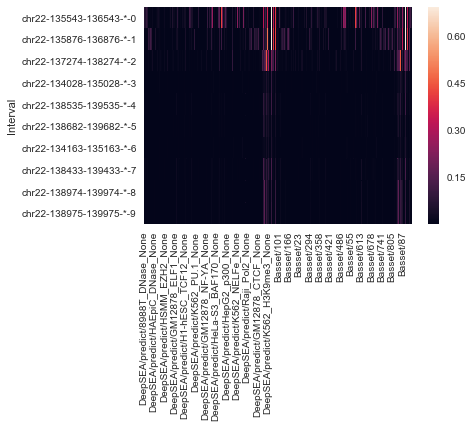

In [52]:
sns.heatmap(df)
plt.ylabel("Interval")

### Loading predictions from the hdf5 output

In [53]:
from kipoi.readers import HDF5Reader

Quick intro to HDF5Reader

In [54]:
f = "output/DeepSEA/predict.h5"

In [55]:
r = HDF5Reader(f)
r.open()

In [56]:
r.ls()

[('/metadata/ranges/chr', <HDF5 dataset "chr": shape (10,), type "|O">),
 ('/metadata/ranges/end', <HDF5 dataset "end": shape (10,), type "<i8">),
 ('/metadata/ranges/id', <HDF5 dataset "id": shape (10,), type "|O">),
 ('/metadata/ranges/start', <HDF5 dataset "start": shape (10,), type "<i8">),
 ('/metadata/ranges/strand', <HDF5 dataset "strand": shape (10,), type "|O">),
 ('/preds', <HDF5 dataset "preds": shape (10, 919), type "<f4">)]

In [57]:
# load the values
d = HDF5Reader.load(f, unflatten=False)

In [58]:
d.keys()

dict_keys(['/metadata/ranges/chr', '/metadata/ranges/end', '/metadata/ranges/id', '/metadata/ranges/start', '/metadata/ranges/strand', '/preds'])

In [59]:
def df2index(df):
    return pd.MultiIndex.from_arrays([df.values[:,i] for i in range(df.shape[1])], names=list(df.columns))


def read_preds_h5(model, output_dir):
    d = HDF5Reader.load("{}/{}.h5".format(output_dir, model), unflatten=False)
    preds = d.pop("/preds")
    
    if preds.ndim == 1:
        preds = preds[:, np.newaxis]
    assert preds.ndim == 2  # this example works only with 2 dim output arrays
    
    metadata_table = pd.DataFrame(d)
    metadata_table.columns = metadata_table.columns.str.replace("^/", "")
    metadata_table = metadata_table[merge_cols]  # re-order
    
    if preds.shape[1] > 1 and model != 'Basset':
        # TODO - remove
        descr = kipoi.get_model_descr(model)
        return pd.DataFrame(preds, 
                            columns=model + "/" + pd.Series(descr.schema.targets.column_labels),
                            index=df2index(metadata_table))
    else:
        return pd.DataFrame(preds, columns = model + "/" + pd.Series(np.arange(preds.shape[1]), dtype=str),
                            index=df2index(metadata_table))

In [60]:
df = pd.concat([read_preds_h5(m, output_dir='output') for m in models], axis=1)

In [61]:
df.head()

DeepSEA/predict/8988T_DNase_None  \
metadata/ranges/chr metadata/ranges/start metadata/ranges/end metadata/ranges/strand metadata/ranges/id                                     
chr22               135543                136543              *                      0                                     0.0816           
                    135876                136876              *                      1                                     0.0670           
                    137274                138274              *                      2                                     0.0445           
                    134028                135028              *                      3                                     0.0025           
                    138535                139535              *                      4                                     0.0008           

                                                                                                         DeepSEA/predict/AoSMC_DNase_None  \
metadata/ranges/chr metadata/ranges/start metadata/ranges/end metadata/ranges/strand metadata/ranges/id                                     
chr22               135543                136543              *                      0                                     0.0687           
                    135876                136876              *                      1                                     0.0106           
                    137274                138274              *                      2                                     0.0054           
                    134028                135028              *                      3                                     0.0005           
                    138535                139535              *                      4                                     0.0054           

                                                                                                         DeepSEA/predict/Chorion_DNase_None  \
metadata/ranges/chr metadata/ranges/start metadata/ranges/end metadata/ranges/strand metadata/ranges/id                                       
chr22               135543                136543              *                      0                                     0.1008             
                    135876                136876              *                      1                                     0.0269             
                    137274                138274              *                      2                                     0.0184             
                    134028                135028              *                      3                                     0.0025             
                    138535                139535              *                      4                                     0.0019             

                                                                                                         DeepSEA/predict/CLL_DNase_None  \
metadata/ranges/chr metadata/ranges/start metadata/ranges/end metadata/ranges/strand metadata/ranges/id                                   
chr22               135543                136543              *                      0                                     0.0029         
                    135876                136876              *                      1                                     0.0139         
                    137274                138274              *                      2                                     0.0156         
                    134028                135028              *                      3                                     0.0007         
                    138535                139535              *                      4                                     0.0005         

                                                                                                         DeepSEA/predict/Fibrobl_DNase_None  \
metadata/r